# A) This notebook offers a comprehensive tutorial on WE data analysis with minimal user input, using the HDF5 file format generated by Wepy.


### https://adicksonlab.github.io/wepy/_source/tutorials/data_analysis/hdf5_access/README.html

In [1]:
from wepy.hdf5 import WepyHDF5
from wepy.analysis.parents import resampling_panel, parent_panel, net_parent_table, ancestors
from wepy.resampling.decisions.clone_merge import MultiCloneMergeDecision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### First load & open the HDF5 file named "wepy.results.h5" with "read" mode. Also provide the time interval between cycles i.e number of MD steps * MD integration time step.

In [20]:
wepy_h5 = WepyHDF5('simdata_run1_steps10000_cycs20000/wepy.results.h5', mode='r')
delta_t = 20  # Time interval between cycles in ps.
wepy_h5.open()

### To extract & display the necessary informations from the HDF5 file for convergence check & MFPT calculation, run the following cell. 

In [21]:
# Print all the basic informations related to the WE simulations
n_walkers = wepy_h5.num_init_walkers(0)       # Number of walkers
warped_walker_idxs = [i[0] for i in list(wepy_h5.h5['/runs/0/warping/walker_idx'])]   # Warped walker ids
cycle_idxs = np.array(list(wepy_h5.h5['/runs/0/warping/_cycle_idxs']))                # Corresponding ids
w_i = wepy_h5.h5['/runs/0/warping/weight']    # weights of the walkers when they reached the target state for the first time
w_i = np.array([i[0] for i in w_i])
T_list = (cycle_idxs*delta_t*0.001*n_walkers)       # Cumulative simulation time points in ns when walkers reach the target

# Always close the HDF5 file after operations
wepy_h5.close()


print('Number of walkers:', n_walkers, '\n')
print('Cycle indices when the walkers reach the target:\n', cycle_idxs, '\n')
print('Indices of the walkers who reach the target (warped walkers):\n', warped_walker_idxs, '\n')
print('Weights of the warped walkers:\n', w_i, '\n')
print('Cumulative simulation time points (ns) when walkers reach the target:\n', T_list, '\n')
print(f'For example: Walker {warped_walker_idxs[0]} reached the target at {cycle_idxs[0]}th cycle with weight {w_i[0]}.')

Number of walkers: 24 

Cycle indices when the walkers reach the target:
 [  31   72   78   78  109  120  121  124  128  138  154  185  185  186
  186  187  188  188  194  195  196  202  206  216  217  217  219  226
  233  234  237  249  250  251  253  262  278  289  290  296  303  312
  327  335  340  341  346  347  379  381  394  398  409  410  419  432
  439  483  521  527  529  533  535  537  575  579  582  582  583  585
  586  589  590  591  593  594  597  605  640  682  699  707  720  732
  733  741  746  751  767  797  805  845  850  871  911  920  922  930
  947  951  955  958  962  971  972  973  991 1064 1078 1123 1125 1159
 1161 1170 1204 1224 1233 1250 1252 1272 1275 1276 1296 1329 1337 1385
 1400] 

Indices of the walkers who reach the target (warped walkers):
 [6, 23, 11, 23, 22, 14, 9, 11, 8, 18, 7, 14, 18, 7, 18, 14, 14, 18, 14, 23, 12, 18, 7, 8, 8, 9, 23, 18, 20, 6, 5, 6, 0, 0, 11, 11, 9, 5, 18, 6, 14, 18, 23, 9, 2, 2, 14, 12, 14, 14, 16, 23, 9, 22, 14, 20, 20, 10, 9, 

### To check convergence, run the following cell. All the necessary informations and the aggregated cumulative probability plot will be printed.

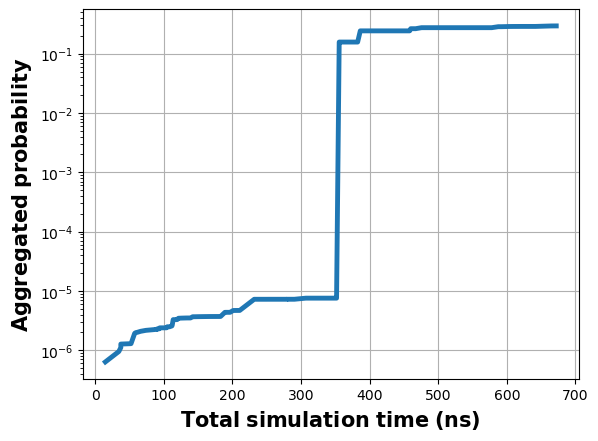

In [22]:
# Plot the data
fig, ax = plt.subplots()
ax.plot(T_list, np.cumsum(w_i), lw=3.5)

ax.set_ylabel(r'$\mathbf{Aggregated\;probability}$', fontsize=15)
ax.set_xlabel(r'$\mathbf{Total\;simulation\;time\;(ns)}$', fontsize=15)
ax.set_yscale("log")
ax.grid('y axis')

### Is the data converged ? If "yes", calculate MFPT by running the following cell.

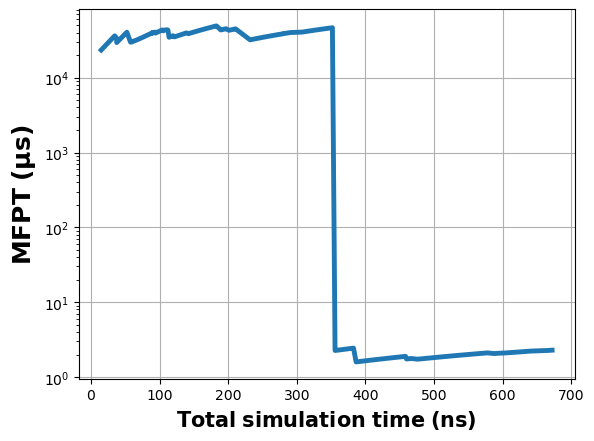

In [25]:
# MFPT calculation according to the eq.2 of the manuscript
mfpt = (T_list/np.cumsum(w_i))*0.001      # in micro sec


# Plot
fig, ax = plt.subplots()
ax.plot(T_list, mfpt, lw=3.5)

ax.set_ylabel(r'$\mathbf{MFPT \;(\mu s)}$', fontsize=18)
ax.set_xlabel(r'$\mathbf{Total\;simulation\;time\;(ns)}$', fontsize=15)
ax.set_yscale("log")
ax.grid('y axis')

### To generate WE productive trajectory (.xtc format), run the following cell with two user defined inputs: 1) Any walker id that reach the target. 2) The corresponding cycle id when that walker reach the target.

### Caution: Time step of the trajectory will be wrong. Change the time step using gmx trjconv -timestep .

In [26]:
############# User defined part #################

walker_id =  6      
cycle_id =  31       

#################################################



wepy_h5.open()
output_file = f'cycle{cycle_id}_walker{walker_id}_productive_traj.xtc'

all_ancestors = []
mod_ances = []

run_idx = 0
    
# Resampling record has information of cloning/merging/squashing/keeping  
resamp_rec = wepy_h5.resampling_records([run_idx])
resamp_panel = resampling_panel(resamp_rec)
par_panel = parent_panel(MultiCloneMergeDecision, resamp_panel)
net_par_table = net_parent_table(par_panel)
 
ances = ancestors(net_par_table, cycle_id, walker_id)
for element in ances:
    mod_ances.append([run_idx, element[0], element[1]])

all_ancestors.append(mod_ances)

# Making trajectory
traj_trace = []
for element in all_ancestors[0]:
    traj_trace.append(tuple(element))
    
traj = wepy_h5.trace_to_mdtraj(traj_trace)
traj.save_xtc(output_file)


print("Frames extraction completed in .xtc format....")

# Always close the HDF5 file after operations
wepy_h5.close()

Frames extraction completed in .xtc format....
